In [1]:
import numpy as np
import random
from collections import defaultdict
from scipy.sparse import csr_matrix
from sklearn.utils import shuffle
from sklearn.metrics import calinski_harabasz_score

In [2]:
def read_csr(filename, filetype="csr", noidx=1):
   
    with open(filename) as f:
        fileline = f.readlines()
    
    if filetype == "csr":
        rows = len(fileline)
        cols = 0 
        nz = 0 
        for i in range(rows):
            p = fileline[i].split()
            if len(p) % 2 != 0:
                raise ValueError("CSR matrix is invalid as the row no %d contains %d numbers." % (i, len(p)))
            nz += int(len(p)/2)
            for j in range(0, len(p), 2): 
                colId = int(p[j]) - noidx
                if colId+1 > cols:
                    cols = colId+1
                    
    elif filetype == "clu":
        p = fileline[0].split()
        rows = int(p[0])
        cols = int(p[1])
        nz = long(p[2])
        fileline = fileline[1:]
        assert(len(fileline) == rows)
        
    else:
        raise ValueError("Sparse matrix is invalid filetype '%s'." % filetype)
    value = np.zeros(nz, dtype=int)
    ind = np.zeros(nz, dtype=int)
    ptr = np.zeros(rows+1, dtype=np.compat.long)
    n = 0 
    for i in range(rows):
        p = fileline[i].split()
        for j in range(0, len(p), 2): 
            ind[n] = int(p[j]) - noidx
            value[n] = int(p[j+1])
            n += 1
        ptr[i+1] = n 
    
    assert(n == nz)
    
    return csr_matrix((val, ind, ptr), shape=(rows, cols), dtype=float)

In [3]:
def idf_csr(mat, copy=False, **arg):
    if copy is True:
        mat = mat.copy()
    rows = mat.shape[0]
    nz = mat.nz
    indices, values, pointer = mat.indices, mat.data, mat.indptr

    defaultDt = defaultdict(int)
    for i in indices:
        defaultDt[i] += 1
    for k,v in defaultDt.items():
        defaultDt[k] = np.log(rows / float(v))  
    for i in range(0, nz):
        values[i] *= defaultDt[indices[i]]
        
    return defaultDt 

if copy is False else mat

In [4]:
def l2normalize_csr(mat, copy=False, **arg):
  
    if copy is True:
        mat = mat.copy()
    rows = mat.shape[0]
    nz = mat.nz
    indices, values, pointer = mat.indices, mat.data, mat.indptr
    for i in range(rows):
        rsum = 0.0    
        for j in range(pointer[i], pointer[i+1]):
            rsum += values[j]**2
        if rsum == 0.0:
            continue
        rsum = float(1.0/np.sqrt(rsum))
        for j in range(pointer[i], pointer[i+1]):
            values[j] *= rsum
            
    if copy is True:
        return mat

In [5]:
def initCentroids(mat):
    matrixShuffled = shuffle(mat, random_state=0)
    return matrixShuffled[:2,:]

In [6]:
def calculateSimilarity(mat, centroids):
    sims = mat.dot(centroids.T)
    return sims

In [7]:
def findingClusters(mat, centroids):
    
    clusterOne = list()
    clusterTwo = list()
    
    simMatrix = calculateSimilarity(mat, centroids)
    
    for index in range(simMatrix.shape[0]):
        simRow = simMatrix[index]
        simSorted = np.argsort(simRow)[-1]
        
        if simSorted == 0:
            clusterOne.append(index)
        else:
            clusterTwo.append(index)
        
    return clusterOne, clusterTwo

In [8]:
def recalculationForNewCentroid(mat, clusters):
    centroids = list()
    
    for i in range(0,2):
        cluster = mat[clusters[i],:]
        clustersMean = cluster.mean(0)
        centroids.append(clustersMean)
        
    centroidsArr = np.asarray(centroids)
    
    return centroidsArr

In [9]:
def kmeansClustering(mat, noOfIterations):
    
    centroids = initCentroids(mat)
    
    for _ in range(noOfIterations):
        
        clusters = list()
        
        clusterOne, clusterTwo = findingClusters(mat, centroids)
        
        if len(clusterOne) > 1:
            clusters.append(clusterOne)
        if len(clusterTwo) > 1:
            clusters.append(clusterTwo)
            
        centroids = recalculationForNewCentroid(mat, clusters)
        
    return clusterOne, clusterTwo

In [10]:
def calSSE(mat, clusters):
    
    list_SSE = list()
    array_SSE = []
    
    for clu in clusters:
        members = mat[clu,:]
        SSE = np.sum(np.square(members - np.mean(members)))
        list_SSE.append(SSE)
        
    array_SSE = np.asarray(list_SSE)
    dropCluIndex = np.argsort(array_SSE)[-1]
            
    return dropCluIndex

In [11]:
def bisecting_kmeans_clustering(mat, k, noOfIterations):
    
    clusters = list()
    
    initcluster = list()
    for i in range(mat.shape[0]):
        initcluster.append(i)
    
    clusters.append(initcluster)
    
    while len(clusters) < k:

        dropCluIndex = calSSE(mat, clusters)
        droppedCluster = clusters[dropCluIndex]
        
        clusterOne, clusterTwo = kmeansClustering(mat[droppedCluster,:], noOfIterations)
        del clusters[dropCluIndex]
        
        actualClusterOne = list()
        actualClusterTwo = list()
        for index in clusterOne:
            actualClusterOne.append(droppedCluster[index])
            
        for index in clusterTwo:
            actualClusterTwo.append(droppedCluster[index])
        
        clusters.append(actualClusterOne)
        clusters.append(actualClusterTwo)
    
    labels = [0] * mat.shape[0]

    for index, cluster in enumerate(clusters):
        for idx in cluster:
            labels[idx] = index + 1
    return labels

In [12]:

inputCSRMatrix = read_csr('train.dat.csr', filetype="csr", noidx=1)
idfCSR = idf_csr(inputCSRMatrix, copy=True)

normalized_csr = l2normalize_csr(idfCSR, copy=True)
denseMatrix = normalized_csr.toarray()

c:\users\ksk\opencv\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\users\ksk\opencv\lib\site-packages\ipykernel_launcher.py:51: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar typ

In [ ]:
kValues = list()
scores = list()

for k in range(3, 22, 2):
    labels = bisecting_kmeans_clustering(denseMatrix, k, 10)
    
    if (k == 7):
        outputFile = open("output.dat", "w")
        for index in labels:
            outputFile.write(str(index) +'\n')
        outputFile.close()

    score = calinski_harabasz_score(denseMatrix, labels)
    kValues.append(k)
    scores.append(score)
    
    print ("For K= %d Calinski Harabaz Score is %f" %(k, score))

For K= 3 Calinski Harabaz Score is 63.080976


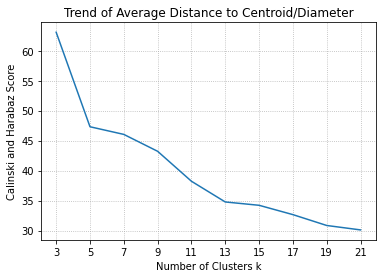

In [14]:
%matplotlib inline
import matplotlib.pyplot as plotter

plotter.plot(kValues, scores)
plotter.xticks(kValues, kValues)
plotter.xlabel('Number of Clusters k')
plotter.ylabel('Calinski - Harabasz Score')
plotter.title('Trend of Average Distance - Diameter')
plotter.grid(linestyle='dotted')

plotter.savefig('plot.png')
plotter.show()